<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/Teacher_student_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

## Preparing Dataset

In [ ]:
# Transformer
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Downloading Data
train_data = datasets.SVHN(root='./data', split = 'train', download=True, transform=transform)
test_data = datasets.SVHN(root='./data', split = 'test', download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(train_data, batch_size= 512, shuffle=True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 512, shuffle=False, num_workers = 2)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
len(train_data), len(test_data), train_data[8][0].shape

(73257, 26032, torch.Size([3, 32, 32]))

## Plottting Images

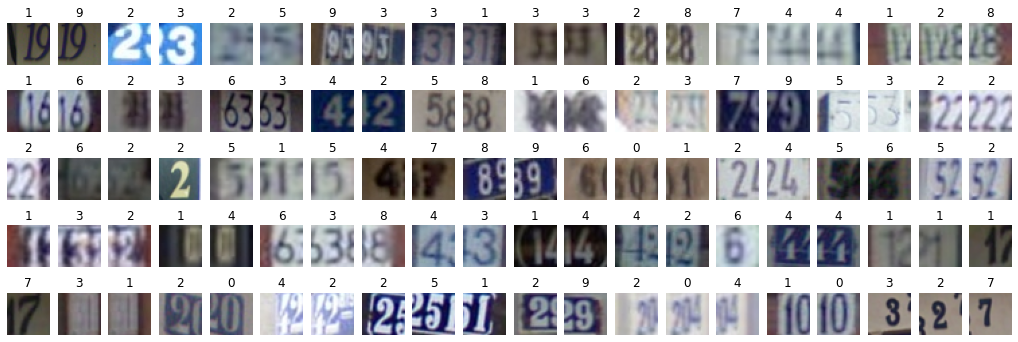

In [ ]:
figure = plt.figure(figsize=(18, 6))
cols, rows = 20, 5


for i in range(cols * rows):
  img, label = train_data[i]
  figure.add_subplot(rows, cols, i + 1)     # starts from 1 that's why added 1

  plt.imshow((img.numpy().transpose(1,2,0)) * 0.5 + 0.5)
 
  plt.title(label)
  plt.axis("off")

plt.show()

# Teacher Model

In [ ]:
# Define the teacher network
class TeacherCNN(nn.Module):
    def __init__(self):
        super(TeacherCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc = nn.Linear(12800, 512)
        self.output = nn.Linear(512, 10)
        self.act = nn.LogSoftmax(dim=1)

        # He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))

        x = self.pool(nn.functional.relu(self.conv5(x)))

        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.relu(self.conv8(x))
        x = nn.functional.relu(self.conv9(x))
        x = nn.functional.relu(self.conv10(x))
        x = x.view(-1, 12800)
        x = self.fc(x)
        x = self.output(x)
        # x = self.act(x)
        return x

### Loss Function and Optimiser

In [ ]:
teacher_model = TeacherCNN().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)


### Training Teacher Network

In [ ]:
loss_history = []
num_epochs = 10
total_instance = 0
correct_instance = 0
for epoch in range(num_epochs):
    loss_sum = 0.0

    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer_teacher.zero_grad()
        outputs = teacher_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer_teacher.step()

        # print statistics
        loss_sum += loss.item()
        _, predicted = outputs.max(1)
        total_instance += targets.size(0)
        correct_instance += predicted.eq(targets).sum().item()

        if i % 60 == 59:  
            print(f'epoch : {epoch + 1},  iterations : {i + 1:5d}     loss: {loss_sum / 60:.3f}     Train Acc: {correct_instance * 100/total_instance:.2f} %')
            loss_history.append(loss_sum / 60)
            loss_sum = 0.0
            total_instance, correct_instance = 0, 0

print('Finished Training.')

epoch : 1,  iterations :    60     loss: 5.113     Train Acc: 17.92 %
epoch : 1,  iterations :   120     loss: 2.172     Train Acc: 22.19 %
epoch : 2,  iterations :    60     loss: 0.992     Train Acc: 62.16 %
epoch : 2,  iterations :   120     loss: 0.728     Train Acc: 77.15 %
epoch : 3,  iterations :    60     loss: 0.494     Train Acc: 84.02 %
epoch : 3,  iterations :   120     loss: 0.412     Train Acc: 87.35 %
epoch : 4,  iterations :    60     loss: 0.336     Train Acc: 89.57 %
epoch : 4,  iterations :   120     loss: 0.304     Train Acc: 90.90 %
epoch : 5,  iterations :    60     loss: 0.285     Train Acc: 91.31 %
epoch : 5,  iterations :   120     loss: 0.253     Train Acc: 92.47 %
epoch : 6,  iterations :    60     loss: 0.220     Train Acc: 93.31 %
epoch : 6,  iterations :   120     loss: 0.214     Train Acc: 93.85 %
epoch : 7,  iterations :    60     loss: 0.193     Train Acc: 94.19 %
epoch : 7,  iterations :   120     loss: 0.193     Train Acc: 94.33 %
epoch : 8,  iteratio

### Loss Curve

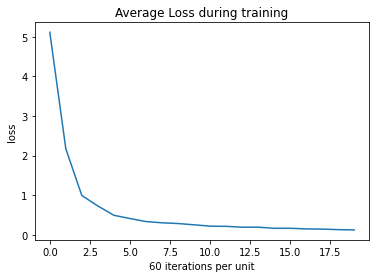

In [ ]:
x_values = range(len(loss_history)) 
plt.plot(x_values,loss_history)
plt.xlabel('60 iterations per unit')
plt.ylabel('loss')
plt.title('Average Loss during training')
plt.show()
     

### Accuracy

In [ ]:
correct_instance = 0
total_instance = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = teacher_model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_instance += labels.size(0)
        correct_instance += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  test images: {100 * correct_instance // total_instance :.3f} %')

Accuracy of the network on the  test images: 91.000 %


# Student Model

In [ ]:
class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc = nn.Linear(6400, 512)
        self.output = nn.Linear(512,10)

        # He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = x.view(-1, 6400)
        x = self.fc(x)
        x = self.output(x)
        return x

## Training the student without Teacher

In [ ]:
student_model = StudentCNN().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer_student = optim.SGD(student_model.parameters(), lr=0.0003, momentum=0.9, weight_decay=5e-4)

In [ ]:
loss_history = []
num_epochs = 10
total_instance = 0
correct_instance = 0
for epoch in range(num_epochs):
    loss_sum = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer_student.zero_grad()
        outputs = student_model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer_student.step()

        # print statistics
        loss_sum += loss.item()
        _, predicted = outputs.max(1)
        total_instance += targets.size(0)
        correct_instance += predicted.eq(targets).sum().item()

        if i % 60 == 59:    
            print(f'epoch : {epoch + 1},  iterations : {i + 1:5d}     loss: {loss_sum / 60:.3f}     Train Acc: {correct_instance * 100/total_instance:.2f} %')
            loss_history.append(loss_sum / 60)
            loss_sum = 0.0
            total_instance, correct_instance = 0, 0



print('Finished Training.')

epoch : 1,  iterations :    60     loss: 2.870     Train Acc: 14.86 %
epoch : 1,  iterations :   120     loss: 2.242     Train Acc: 19.81 %
epoch : 2,  iterations :    60     loss: 2.181     Train Acc: 22.27 %
epoch : 2,  iterations :   120     loss: 2.158     Train Acc: 24.14 %
epoch : 3,  iterations :    60     loss: 2.111     Train Acc: 25.80 %
epoch : 3,  iterations :   120     loss: 2.058     Train Acc: 29.20 %
epoch : 4,  iterations :    60     loss: 1.988     Train Acc: 31.54 %
epoch : 4,  iterations :   120     loss: 1.901     Train Acc: 36.16 %
epoch : 5,  iterations :    60     loss: 1.765     Train Acc: 40.64 %
epoch : 5,  iterations :   120     loss: 1.667     Train Acc: 45.31 %
epoch : 6,  iterations :    60     loss: 1.518     Train Acc: 50.26 %
epoch : 6,  iterations :   120     loss: 1.392     Train Acc: 55.73 %
epoch : 7,  iterations :    60     loss: 1.266     Train Acc: 58.95 %
epoch : 7,  iterations :   120     loss: 1.186     Train Acc: 62.85 %
epoch : 8,  iteratio

### Loss Curve

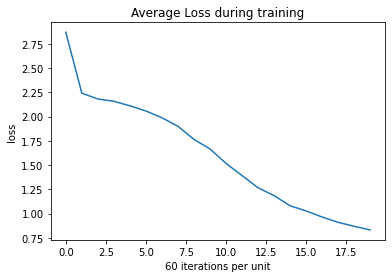

In [ ]:
x_values = range(len(loss_history)) 
plt.plot(x_values,loss_history)
plt.xlabel('60 iterations per unit')
plt.ylabel('loss')
plt.title('Average Loss during training')
plt.show()

### Accuracy

In [ ]:
correct_instance = 0
total_instance = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = student_model(images)

        _, predicted = torch.max(outputs.data, 1)
        total_instance += labels.size(0)
        correct_instance += (predicted == labels).sum().item()

print(f'Accuracy of the network on the  test images: {100 * correct_instance // total_instance :.3f} %')

Accuracy of the network on the  test images: 74.000 %




---



## Training the Student with the help of Teacher

In [ ]:
student_model_distill = StudentCNN().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer_student = optim.SGD(student_model_distill.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

### Distillation Loss Class

In [ ]:
class DistillationLossClass:
    def __init__(self):
        self.student_loss = nn.CrossEntropyLoss()
        self.loss_distilled = nn.KLDivLoss()
        self.temp = 1
        self.alpha = 0.2

    def __call__(self, student_logits, student_target_loss, teacher_logits):
        loss_distilled = self.loss_distilled(F.log_softmax(student_logits / self.temp, dim=1),
                                                   F.softmax(teacher_logits / self.temp, dim=1))

        loss = (1 - self.alpha) * student_target_loss + self.alpha * loss_distilled
        return loss

### Training

In [ ]:
loss_history = []
num_epochs = 10
total_instance = 0
correct_instance = 0

for epoch in range(num_epochs):
    loss_sum = 0.0
    # enumerate mini batches
    # i is batch_indx
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer_student.zero_grad()
        outputs_teacher = teacher_model(inputs).detach()
        outputs_student = student_model_distill(inputs)

        student_logits = outputs_student
        student_target_loss = loss_function(outputs_student, targets)
        teacher_logits = outputs_teacher

        loss_distilled = DistillationLossClass()
        loss = loss_distilled(student_logits,student_target_loss,teacher_logits)

        loss.backward()
        optimizer_student.step()

        # print statistics
        loss_sum += loss.item()
        _, predicted = outputs_student.max(1)
        total_instance += targets.size(0)
        correct_instance += predicted.eq(targets).sum().item()

        if i % 60 == 59:    # print every 40 mini-batches
            print(f'epoch : {epoch + 1},  iterations : {i + 1:5d}     loss: {loss_sum / 60:.3f}     Train Acc: {correct_instance * 100/total_instance:.2f} %')
            loss_history.append(loss_sum / 60)
            loss_sum = 0.0
            total_instance, correct_instance = 0, 0



print('Finished Training.')

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch : 1,  iterations :    60     loss: 2.027     Train Acc: 17.71 %
epoch : 1,  iterations :   120     loss: 1.835     Train Acc: 18.68 %
epoch : 2,  iterations :    60     loss: 1.834     Train Acc: 19.03 %
epoch : 2,  iterations :   120     loss: 1.834     Train Acc: 18.87 %
epoch : 3,  iterations :    60     loss: 1.827     Train Acc: 19.00 %
epoch : 3,  iterations :   120     loss: 1.659     Train Acc: 28.55 %
epoch : 4,  iterations :    60     loss: 0.958     Train Acc: 59.62 %
epoch : 4,  iterations :   120     loss: 0.773     Train Acc: 71.44 %
epoch : 5,  iterations :    60     loss: 0.674     Train Acc: 74.97 %
epoch : 5,  iterations :   120     loss: 0.629     Train Acc: 77.11 %
epoch : 6,  iterations :    60     loss: 0.605     Train Acc: 77.85 %
epoch : 6,  iterations :   120     loss: 0.581     Train Acc: 78.97 %
epoch : 7,  iterations :    60     loss: 0.571     Train Acc: 79.10 %
epoch : 7,  iterations :   120     loss: 0.546     Train Acc: 80.15 %
epoch : 8,  iteratio

### Loss Curve

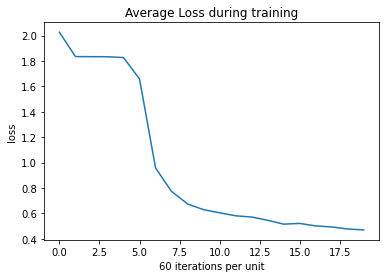

In [ ]:
x_values = range(len(loss_history)) 
plt.plot(x_values,loss_history)
plt.xlabel('60 iterations per unit')
plt.ylabel('loss')
plt.title('Average Loss during training')
plt.show()

### Accuracy

In [ ]:
correct_instance = 0
total_instance = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = student_model_distill(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total_instance += labels.size(0)
        correct_instance += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct_instance // total_instance :.3f} %')

Accuracy of the network on the test images: 81.000 %




---



---

